# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In this section, we will prepare the training and testing data for the LSTM model.

We will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the `X` and `y` values
4. Reshape the `X_train` and `X_test` data for the model.

**Note:** The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [305]:
# Initial imports
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
from pathlib import Path
import keras_tuner as kt

%matplotlib inline

In [306]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

### Data Loading

In this activity, we will use closing prices from different stocks to make predictions of future closing prices based on the temporal data of each stock.

In [307]:
# # Load the stocks data
# df = pd.read_csv(
#     Path("../Resources/stock_data.csv"),
#     index_col="date",
#     infer_datetime_format=True,
#     parse_dates=True,
# )
# df.head()

In [308]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [309]:
!rm -rf ./logs/

In [310]:
import yfinance as yf

btcdata = yf.download("ETH-USD", start="2020-04-01", end="2022-04-07")
df = pd.DataFrame(btcdata)
df.drop(columns=['Adj Close'],inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-01,133.612320,135.634552,129.730942,135.634552,12456564435
2020-04-02,135.732178,146.787094,135.732178,142.029144,15322861686
2020-04-03,142.110458,146.899872,139.619385,142.091309,13184603402
2020-04-04,142.215179,145.377304,140.121826,145.219391,11946658257
2020-04-05,145.261017,146.128525,142.102081,143.546646,11280993591
...,...,...,...,...,...
2022-04-03,3444.810547,3573.960205,3421.259766,3522.833496,15333808649
2022-04-04,3522.364990,3535.148193,3422.000977,3521.241211,18209969743
2022-04-05,3521.239746,3546.706787,3410.547607,3411.792480,16681503199


<AxesSubplot:xlabel='Date'>

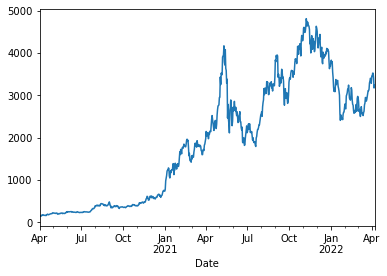

In [311]:
df.Close.plot()

### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [312]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `5` days windows of previous _T-Bonds_ closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `5` and setting the features and target column numbers to `2` (this is the column with the _T-Bonds_ closing prices).

In [313]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 10

feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[135.634552   142.02914429 142.09130859 145.21939087 143.54664612
  169.13587952 165.10194397 172.64173889 170.80714417 158.41244507]
 [142.02914429 142.09130859 145.21939087 143.54664612 169.13587952
  165.10194397 172.64173889 170.80714417 158.41244507 158.21601868]
 [142.09130859 145.21939087 143.54664612 169.13587952 165.10194397
  172.64173889 170.80714417 158.41244507 158.21601868 161.14242554]
 [145.21939087 143.54664612 169.13587952 165.10194397 172.64173889
  170.80714417 158.41244507 158.21601868 161.14242554 156.27955627]
 [143.54664612 169.13587952 165.10194397 172.64173889 170.80714417
  158.41244507 158.21601868 161.14242554 156.27955627 157.59638977]] 

y sample values:
[[158.21601868]
 [161.14242554]
 [156.27955627]
 [157.59638977]
 [153.28689575]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [314]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that we scale both features and target sets.

In [315]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [316]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [4.15572804e-04]
  [0.00000000e+00]
  [3.94703577e-03]
  [2.94242322e-03]
  [4.82013606e-03]
  [4.36324803e-03]
  [1.27646837e-03]]

 [[1.58554095e-03]
  [1.54381351e-05]
  [7.76852584e-04]
  [0.00000000e+00]
  [6.35732945e-03]
  [2.94242322e-03]
  [4.82013606e-03]
  [4.36324803e-03]
  [1.27646837e-03]
  [1.22755028e-03]]

 [[1.60095461e-03]
  [7.92278726e-04]
  [3.61429981e-04]
  [6.35732945e-03]
  [5.35514791e-03]
  [4.82013606e-03]
  [4.36324803e-03]
  [1.27646837e-03]
  [1.22755028e-03]
  [1.95634354e-03]]

 [[2.37656349e-03]
  [3.76862536e-04]
  [6.71646170e-03]
  [5.35514791e-03]
  [7.22831697e-03]
  [4.36324803e-03]
  [1.27646837e-03]
  [1.22755028e-03]
  [1.95634354e-03]
  [7.45293092e-04]]

 [[1.96180596e-03]
  [6.73179614e-03]
  [5.71464238e-03]
  [7.22831697e-03]
  [6.77253454e-03]
  [1.27646837e-03]
  [1.22755028e-03]
  [1.95634354e-03]
  [7.45293092e-04]
  [1.07323771e-03]]] 

X_test sample v

---

## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [317]:
# Import required Keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [318]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([5, 32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
#
# METRIC_ACCURACY = 'accuracy'
#
# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#   hp.hparams_config(
#     hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#   )


In [319]:
# Define the LSTM RNN model.
def model_builder(hp):
    model = Sequential()

    hp_units = hp.Int('units', min_value=2, max_value=218, step=32)
    dropout_fraction = 0.2
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Layer 1
    model.add(LSTM(
        units=hp_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=hp_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=hp_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mean_squared_error",metrics=['accuracy'])
    model.summary()
    return model

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [320]:
import shutil

dir_path = 'my_dir'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

In [321]:



tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 20 Complete [00h 00m 06s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 66 and the optimal learning rate for the optimizer
is 0.001.



### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [322]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 66)            17952     
                                                                 
 dropout_3 (Dropout)         (None, 10, 66)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 66)            35112     
                                                                 
 dropout_4 (Dropout)         (None, 10, 66)            0         
                                                                 
 lstm_5 (LSTM)               (None, 66)                35112     
                                                                 
 dropout_5 (Dropout)         (None, 66)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

---
## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [323]:
# Evaluate the model
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)


#model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 0.0000e+00
[test loss, test accuracy]: [0.006057047285139561, 0.0]


### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [324]:
# Make some predictions
predicted = hypermodel.predict(X_test)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

We will use the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [325]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [326]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2021-09-01,3834.828125,3169.086426
2021-09-02,3790.989990,3178.860107
2021-09-03,3940.614746,3190.385986
2021-09-04,3887.828369,3238.222168
2021-09-05,3952.133545,3293.350830


<AxesSubplot:xlabel='Date'>

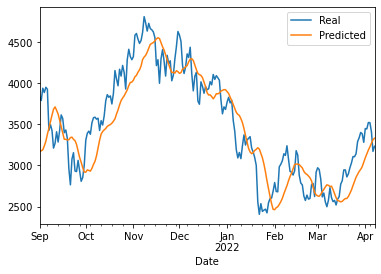

In [327]:
# Plot the real vs predicted prices as a line chart
stocks.plot()